<a href="https://colab.research.google.com/github/AlirezaFazli29/Whisper/blob/main/Whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whisper

## Libraries

In [3]:
! pip install --upgrade pip
! pip install --upgrade git+https:/|/github.com/huggingface/transformers.git accelerate datasets[audio]
! pip install torchinfo

/bin/bash: line 1: /github.com/huggingface/transformers.git: No such file or directory
ERROR: Pipe to stdout was broken
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchinfo import summary
import soundfile as sf

## Default Device

In [ ]:
if torch.cuda.is_available(): print(torch.cuda.get_device_name())
else: print('cpu')
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

Tesla T4


## Model

In [ ]:
model_id = "openai/whisper-large-v3"
batch_size = 16
model = AutoModelForSpeechSeq2Seq.from_pretrained(pretrained_model_name_or_path=model_id).to(default_device)
processor = AutoProcessor.from_pretrained(model_id)
pipe = pipeline("automatic-speech-recognition",
                model=model,
                tokenizer=processor.tokenizer,
                feature_extractor=processor.feature_extractor,
                max_new_tokens=128,
                chunk_length_s=30,
                batch_size=batch_size,
                return_timestamps=True,
                device=default_device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Dataset

In [ ]:
dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")

In [ ]:
dataset[0]

{'audio': {'path': '0d38672e0bbdbdc460af55b8bb84a15b2730db2819f2af64f9c777d4d586f2de',
  'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00024414, 0.00048828,
         0.0005188 ]),
  'sampling_rate': 16000}}

In [ ]:
test = dataset[0]['audio']

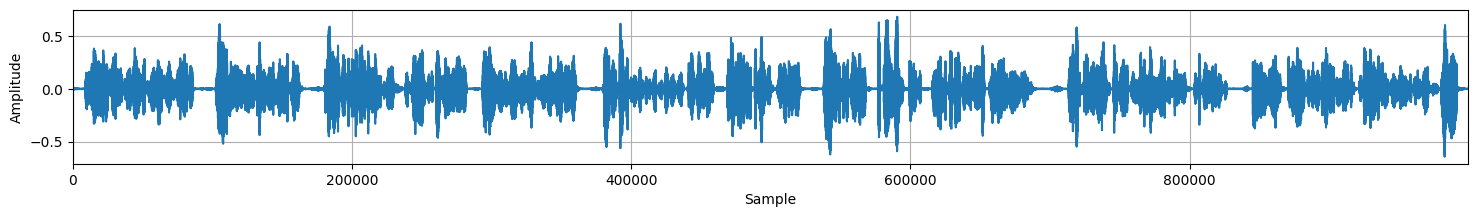

In [ ]:
plt.figure(figsize=(18,2))
plt.grid()
plt.xlim(left=0,right=len(test['array']))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(test['array'])
plt.show()

In [ ]:
Audio(test['array'], rate=test['sampling_rate'])

In [ ]:
result = pipe(test, generate_kwargs={"language": "english"})
result['text']

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed language=english, but also have set `forced_decoder_ids` to [[1, None], [2, 50360]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=english.


" Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel. Nor is Mr. Quilter's manner less interesting than his matter. He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind. He has grave doubts whether Sir Frederick Leighton's work is really Greek after all, and can discover in it but little of rocky Ithaca. Linnell's pictures are a sort of Upguards and Adam paintings, and Mason's exquisite idylls are as national as a jingo poem. Mr. Burkett Foster's landscapes smile at one much in the same way that Mr. Carker used to flash his teeth. And Mr. John Collier gives his sitter a cheerful slap on the back before he says, like a shampooer in a Turkish bath, Next man!"

In [ ]:
test , sr = sf.read("audio_2024-06-01_13-44-20.ogg")
result = pipe("audio_2024-06-01_13-44-20.ogg")
result['text']

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


' How was your weekend? Well, actually I got a little sick. Oh really? Sorry to hear that, man. Yeah, Bullets Over Broadway was on TV. I came down with a big old Diane Wiest infection.'

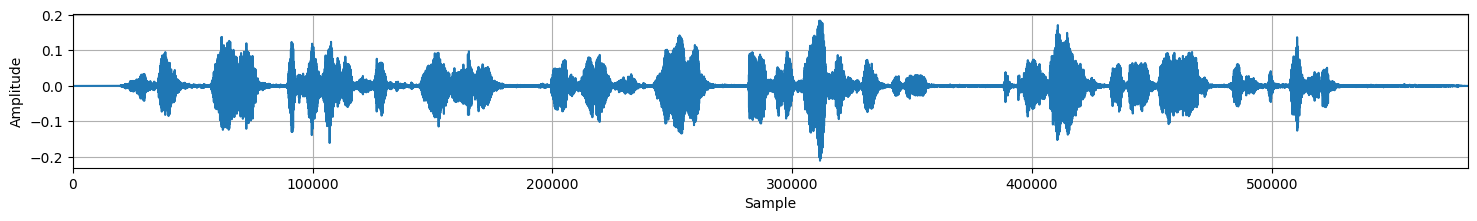

In [ ]:
plt.figure(figsize=(18,2))
plt.grid()
plt.xlim(left=0,right=len(test))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(test)
plt.show()

In [ ]:
Audio(test, rate=sr)

In [ ]:
pipe({'array': test, 'sampling_rate':sr})['text']

' How was your weekend? Well, actually I got a little sick. Oh really? Sorry to hear that, man. Yeah, Bullets Over Broadway was on TV. I came down with a big old Diane Wiest infection.'

In [ ]:
result

{'text': " I have read the stories of the world. So I have heard each of the weird ones that come out. I'm going to go to sleep now. I can't hold it any longer. I'm going to sleep now.",
 'chunks': [{'timestamp': (0.0, 12.0),
   'text': ' I have read the stories of the world.'},
  {'timestamp': (12.0, 29.0),
   'text': " So I have heard each of the weird ones that come out. I'm going to go to sleep now. I can't hold it any longer."},
  {'timestamp': (30.0, 33.0), 'text': " I'm going to sleep now."}]}

## rest

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
WhisperForConditionalGeneration                         --
├─WhisperModel: 1-1                                     --
│    └─WhisperEncoder: 2-1                              --
│    │    └─Conv1d: 3-1                                 492,800
│    │    └─Conv1d: 3-2                                 4,916,480
│    │    └─Embedding: 3-3                              (1,920,000)
│    │    └─ModuleList: 3-4                             629,637,120
│    │    └─LayerNorm: 3-5                              2,560
│    └─WhisperDecoder: 2-2                              --
│    │    └─Embedding: 3-6                              66,388,480
│    │    └─WhisperPositionalEmbedding: 3-7             573,440
│    │    └─ModuleList: 3-8                             839,557,120
│    │    └─LayerNorm: 3-9                              2,560
├─Linear: 1-2                                           66,388,480
Total params: 1,609,879,040
Trainable params

In [ ]:
farsi = pipe("Tehran_Aghrabe0_88.wav")
farsi['text']

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


' در کنار شما باشین'

In [ ]:
data, sr = sf.read("Tehran_Aghrabe0_68.wav")

In [ ]:
Audio(data, rate=sr)

In [ ]:
test = {'array': data,
        'sampling_rate': sr}
farsi = pipe(test)
farsi['text']

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


' موسیقی خب دوستان فعلا نمره دادن به ما بیشتر تا این که در مورد'